# Compute the approximate CHEOPS count rate

[CHEOPS red book](https://sci.esa.int/documents/34375/36249/1567259940843-CHEOPS_EST_SCI_RP_001_RedBook_i1.0.pdf)

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.constants import R_earth, R_sun

import tynt
from synphot.spectrum import SpectralElement, SourceSpectrum
from synphot.observation import Observation
from synphot import BlackBody1D
from synphot.models import Empirical1D

Set parameters for white dwarf and CHEOPS:

In [36]:
# Parameters for WD 1134+300
distance = (63.7842 * u.mas).to(u.pc, u.parallax())
T_eff = 22000 * u.K
stellar_radius = 1 * R_earth

# CHEOPS props:
aperture_radius = 30 / 2 * u.cm  # radius of 3.5m ARC telescope at APO
gain = 1.9  # the gain of this detector in e-/ADU
band = 'GAIA/GAIA0.G' # CHEOPS bp is approx Gaia G

Set source spectrum to blackbody:

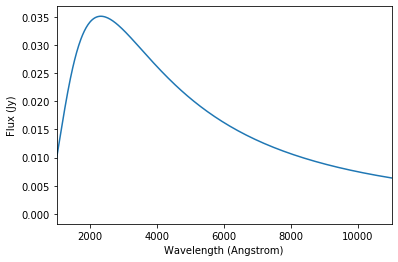

In [54]:
photlam = SourceSpectrum(BlackBody1D, temperature=T_eff)

# Scale the flux to get the value at Earth
photlam = photlam * float(stellar_radius / distance) ** 2

photlam.plot(flux_unit='Jy', left=1000, right=11000)

Approximate the filter bandpass: 

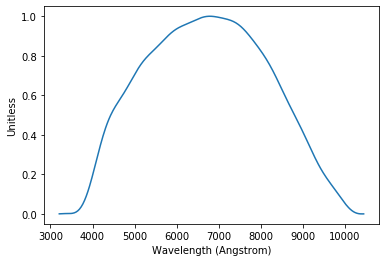

In [56]:
f = tynt.FilterGenerator()

filt = f.reconstruct(band)
bp = SpectralElement(Empirical1D,
                     points=filt.wavelength,
                     lookup_table=filt.transmittance)
bp.plot()

Approximate quantum efficiency of a typical CCD: 

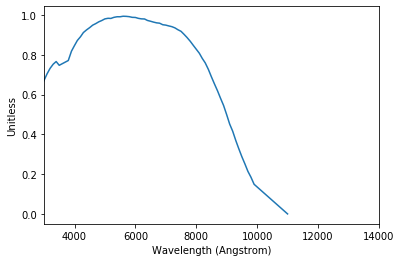

In [57]:
quantum_efficiency = SpectralElement.from_file('../aspros/data/ccd_QE.csv', wave_unit="nm")
quantum_efficiency = quantum_efficiency / 100  # convert percentages to decimals

quantum_efficiency.plot(left=3000, right=14000)

Compute the count rate: 

In [63]:
observation = Observation(photlam, bp * quantum_efficiency)
aperture_area = np.pi * aperture_radius ** 2
countrate = observation.countrate(area=aperture_area) / gain

countrate

<Quantity 5226.85283403 ct / s>

In [66]:
with open('../aspros/data/count_rate.txt', 'w') as w: 
    w.write(str(countrate.to(u.ct/u.s).value))